In [31]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import os
import pickle
import random

from scipy.io import wavfile
from scipy import signal

import librosa

from pydub import AudioSegment
from pydub.playback import play

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model, save_model

RECORDINGS_FOLDER_PATH = "./recordings"

In [32]:
# A dictionary of dictionaries of lists.
# Outer dict: {bird name: dictionary of audio data}
# Inner dict: {sampling rate: list of data}

def load_data():
    bird_dict = {}
    for folder in os.listdir(RECORDINGS_FOLDER_PATH)[1:]:
        if not folder.startswith('.'):
            files = os.listdir(os.path.join(RECORDINGS_FOLDER_PATH, folder))
        for file in files:
            if file.endswith(".mp3") and file[:-3]+"wav" not in files:
                file_path = os.path.join(RECORDINGS_FOLDER_PATH, folder, file)
                audio = AudioSegment.from_mp3(file_path)
                mono_audio = audio.set_channels(1)
                mono_audio.export(file_path[:-3] + "wav", format="wav")
            elif file.endswith(".wav"):
                bird = file.split(" - ")[1]
                if bird not in bird_dict:
                    bird_dict[bird] = {}
                full_path = os.path.join(RECORDINGS_FOLDER_PATH, folder, file)
                sample_rate, data = wavfile.read(full_path)
                if sample_rate not in bird_dict[bird]:
                    bird_dict[bird][sample_rate] = []
                if len(data) > 10*sample_rate:
                  data = data[:10*sample_rate]
                else:
                  data = np.concatenate([data, np.zeros(10*sample_rate - len(data))])
                max_abs_value = np.max(np.abs(data))
                normalized_data = data / max_abs_value
                bird_dict[bird][sample_rate].append(normalized_data)
    return bird_dict

bird_dict = {}

# bird_dict = load_data()
# with open('bird_dict.pkl', 'wb') as f:
    # pickle.dump(bird_dict, f)

with open('bird_dict.pkl', 'rb') as f:
    bird_dict = pickle.load(f)

In [33]:
'''
data - audio samples to overlap
frac - amount to overlap (0 -> 1). This is proportion of the way through the prior signal it will appear.
'''
def overlap(*data, sample_rate=44100, frac=1):
  if not 0 < frac <= 1:
    print("Make sure you abide by 0 < 'frac' <= 1")
    return None
  if len(data) >= 2:
    first = data[0]
    second = data[1]
    delay = np.zeros(int((1-frac) * len(first)))
    delayed_second = np.concatenate([delay, second])
    padded_first = first
    if len(delayed_second) > len(first):
        padding_amt = len(delayed_second) - len(first)
        padding = np.zeros(padding_amt)
        padded_first = np.concatenate([first, padding])
    else:
        padding_amt = len(first) - len(delayed_second)
        padding = np.zeros(padding_amt)
        delayed_second = np.concatenate([delayed_second, padding])
    return padded_first + delayed_second
  else:
     return data

In [171]:
def filter_audio(audio):
  fs = 44100

  # band-pass filter
  sos = signal.butter(10, [1000, 8000], 'bp', fs=fs, output='sos')
  filtered_sig = signal.sosfilt(sos, audio)
  f, t, filtered = signal.stft(filtered_sig, fs)

  # crop frequency
  # indices = np.where((f >= 1000) & (f <= 8000))
  # filtered_freq = f[indices]
  # filtered_stft = filtered[indices, :]

  # pcen
  pcen_sig = librosa.pcen(abs(filtered)**2, sr=fs)

  # normalize
  min_val = np.min(pcen_sig)
  max_val = np.max(pcen_sig)
  sig = (pcen_sig - min_val) / (max_val - min_val)
  return t, f, sig


def temporal_rolloff(frame, N=0.9):
  total_power = np.sum(frame)
  target_power = 0.9 * total_power
  center_index = len(frame) // 2

  left_index = center_index
  right_index = center_index
  current_power = frame[center_index]
  while current_power < target_power and not ((left_index == 0) and (right_index == len(frame) - 1)):
    left_power = -math.inf
    right_power = -math.inf
    if left_index > 0:
      left_power = frame[left_index - 1]
    if right_index < (len(frame) - 1):
      right_power = frame[right_index + 1]

    if left_power >= right_power:
      left_index -= 1
      current_power += frame[left_index]
    else: # right_power > left_power
      right_index += 1
      current_power += frame[right_index]
  return right_index - left_index


def sliding_window(matrix, t, f, threshold=-100):
  height, width = matrix.shape
  windows_per_second = 200
  fs = 44100
  window_width = width // windows_per_second
  window_height = 2
  mat = np.zeros(height*width).reshape((height, width))
  F = []

  x_stride = window_width // 2  # Overlap is set to half the window size
  y_stride = window_height // 2

  windows = 0
  for y in range(0, height-y_stride, y_stride):
    for x in range(0, width-x_stride, x_stride):
      windows += 1
      window = matrix[y:y + window_height, x:x + window_width]
      max_value = np.max(window)
      if max_value > threshold:
        max_position = np.unravel_index(np.argmax(window), window.shape)
        # KP-SVM
        # Spectral rolloff
        spec_rolloff = librosa.feature.spectral_rolloff(S=abs(window).astype(float), sr=fs, roll_percent=0.9)[0][0]
        # Temporal rolloff
        avg_t = window.mean(axis=0)
        temp_rolloff = temporal_rolloff(avg_t)
        # Energy
        ste = np.mean(abs(window))

        F.append((max_value, t[x + window_height//2], f[y + window_width//2], spec_rolloff, temp_rolloff, ste))

        # KP-CNN
        mat[y + window_height//2, x + window_width//2] = max_value
  # print("Searched with {} sliding windows".format(windows))
  # print("Found {} keypoints".format(len(F)))
  return np.array(F), mat


def get_keypoints(audio, N=None):
  t, f, filtered_audio = filter_audio(audio)
  # filtered_audio = signal.stft(audio, 44100)[-1]
  thresh = np.percentile(np.real(filtered_audio[filtered_audio != 0]), 99.5)
  kps, mat = sliding_window(np.real(filtered_audio), t, f, threshold=thresh)
  if N is not None:
    kps = kps[kps[:, -1].argsort()]

    flattened_sorted = np.sort(mat.flatten())
    threshold_value = flattened_sorted[-N]
    mat = np.where(mat < threshold_value, 0, 1)
  kps = kps[:N]
  return t, f, filtered_audio, kps, mat


def graph_keypoints(t, f, kps, background=False, original=None):
  plt.figure(figsize=(9, 4))
  # out = mat
  # if background:
  #   original_spec = filter_audio(original)[-1]
  #   out = mat+np.real(abs(original_spec))

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2.5))
  plt.subplots_adjust(hspace=0.5, wspace=0.5)

  ax.pcolormesh(t, f, np.real(abs(signal.stft(original)[-1])), vmax=original.max()/3, shading="nearest")

  ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
  ax.minorticks_on()

  ax.scatter(kps[:, 1], kps[:, 2], color='red', label='Highlighted Points', s=3)
  
  fig.text(0.5, 0, 'Time (s)', ha='center', fontsize=10)
  fig.text(0, 0.5, 'Frequency (Hz)', va='center', rotation='vertical', fontsize=10)
  fig.suptitle('Keypoints on Full-Spectrogram')

  # plt.savefig('figures/keypoints_full.png', dpi=300, bbox_inches='tight')
  plt.tight_layout()
  plt.show()

<Figure size 900x400 with 0 Axes>

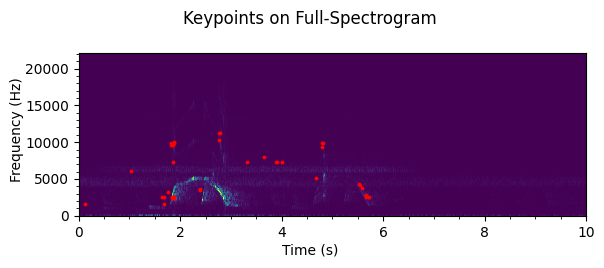

In [120]:
t, f, filtered_audio, kps, mat = get_keypoints(overlap_sample, 40)
graph_keypoints(t, f, kps, background=True, original=overlap_sample)

In [122]:
np.diff(f)

array([172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265625,
       172.265625, 172.265625, 172.265625, 172.265625, 172.265

<Figure size 900x400 with 0 Axes>

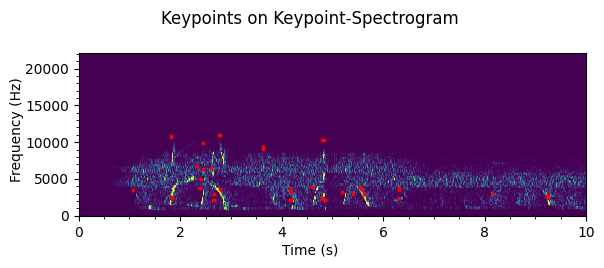

In [118]:
t, f, filtered_audio, kps, mat = get_keypoints(overlap_sample, 40)
graph_keypoints(t, f, kps, background=True, original=overlap_sample)

In [35]:
def generate_samples(N, n, fs=44100):
  labels = ['Straight-billed Woodcreeper', 'Screaming Piha', 'Squirrel Cuckoo', 'White-necked Thrush']
  birds = list(bird_dict.keys())
  X = []
  y = []
  m = []
  bl = []
  for i in range(N):
    bird_ab = np.random.choice(birds, 2, replace=False)
    to_overlap = []
    for b in bird_ab:
      population = None
      if b == birds[0]:
        population = bird_dict[birds[0]][fs][:100]
      elif b == birds[1]:
        population = bird_dict[birds[1]][fs][-100:]
      elif b == birds[2]:
        population = bird_dict[birds[2]][fs][20:70] + bird_dict[birds[2]][fs][85:135]
      else:
        population = bird_dict[birds[3]][fs][-50:-29] + bird_dict[birds[3]][fs][-100:-60] + bird_dict[birds[3]][fs][:39]
      to_overlap.append(population[np.random.choice(np.arange(len(population)))])

    overlap_sample = to_overlap[0] + to_overlap[1]

    t, f, filtered_audio, kps, mat = get_keypoints(overlap_sample, n)
    _t, _f, baseline = filter_audio(overlap_sample)
    X.append(kps.flatten())
    y.append([labels.index(bird_ab[0]), labels.index(bird_ab[1])])
    m.append(mat)
    bl.append(baseline)
  return X, y, np.array(m), np.array(bl)

In [36]:
for bird in bird_dict.keys():
    print(bird + ": ")
    for fs in bird_dict[bird].keys():
        print("\t{} has {} samples".format(fs, len(bird_dict[bird][fs])))

White-necked Thrush: 
	48000 has 38 samples
	44100 has 171 samples
	32000 has 2 samples
	16000 has 3 samples
	22050 has 7 samples
Screaming Piha: 
	48000 has 69 samples
	44100 has 268 samples
	16000 has 7 samples
	22050 has 13 samples
	24000 has 2 samples
	32000 has 2 samples
Straight-billed Woodcreeper: 
	44100 has 178 samples
	48000 has 36 samples
	32000 has 2 samples
	22050 has 5 samples
	16000 has 4 samples
Squirrel Cuckoo: 
	44100 has 313 samples
	48000 has 72 samples
	32000 has 3 samples
	24000 has 2 samples
	22050 has 5 samples
	16000 has 3 samples


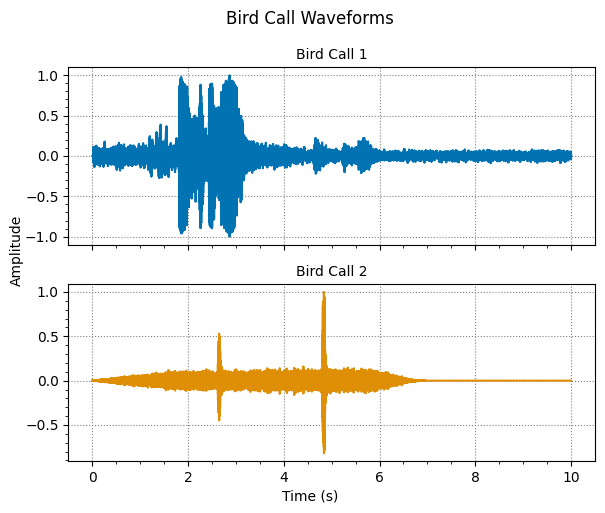

In [37]:
fs = 44100
single_sample_1 = bird_dict["Screaming Piha"][fs][0]
single_sample_2 = bird_dict["Squirrel Cuckoo"][fs][0]

colors = sns.color_palette("colorblind")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

axes[0].plot(np.arange(len(single_sample_1)) / fs, single_sample_1, color=colors[0])
axes[0].set_title("Bird Call 1", fontsize=10)

axes[1].plot(np.arange(len(single_sample_2)) / fs, single_sample_2, color=colors[1])
axes[1].set_title("Bird Call 2", fontsize=10)

axes[0].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axes[1].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
axes[0].minorticks_on()
axes[1].minorticks_on()
axes[0].grid(True, linestyle=':', linewidth=0.8, color='gray')
axes[1].grid(True, linestyle=':', linewidth=0.8, color='gray')

fig.text(0.5, 0, 'Time (s)', ha='center', fontsize=10)
fig.text(0, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Bird Call Waveforms')

# plt.savefig('figures/bird_call_waveforms.png')
plt.tight_layout()
plt.show()

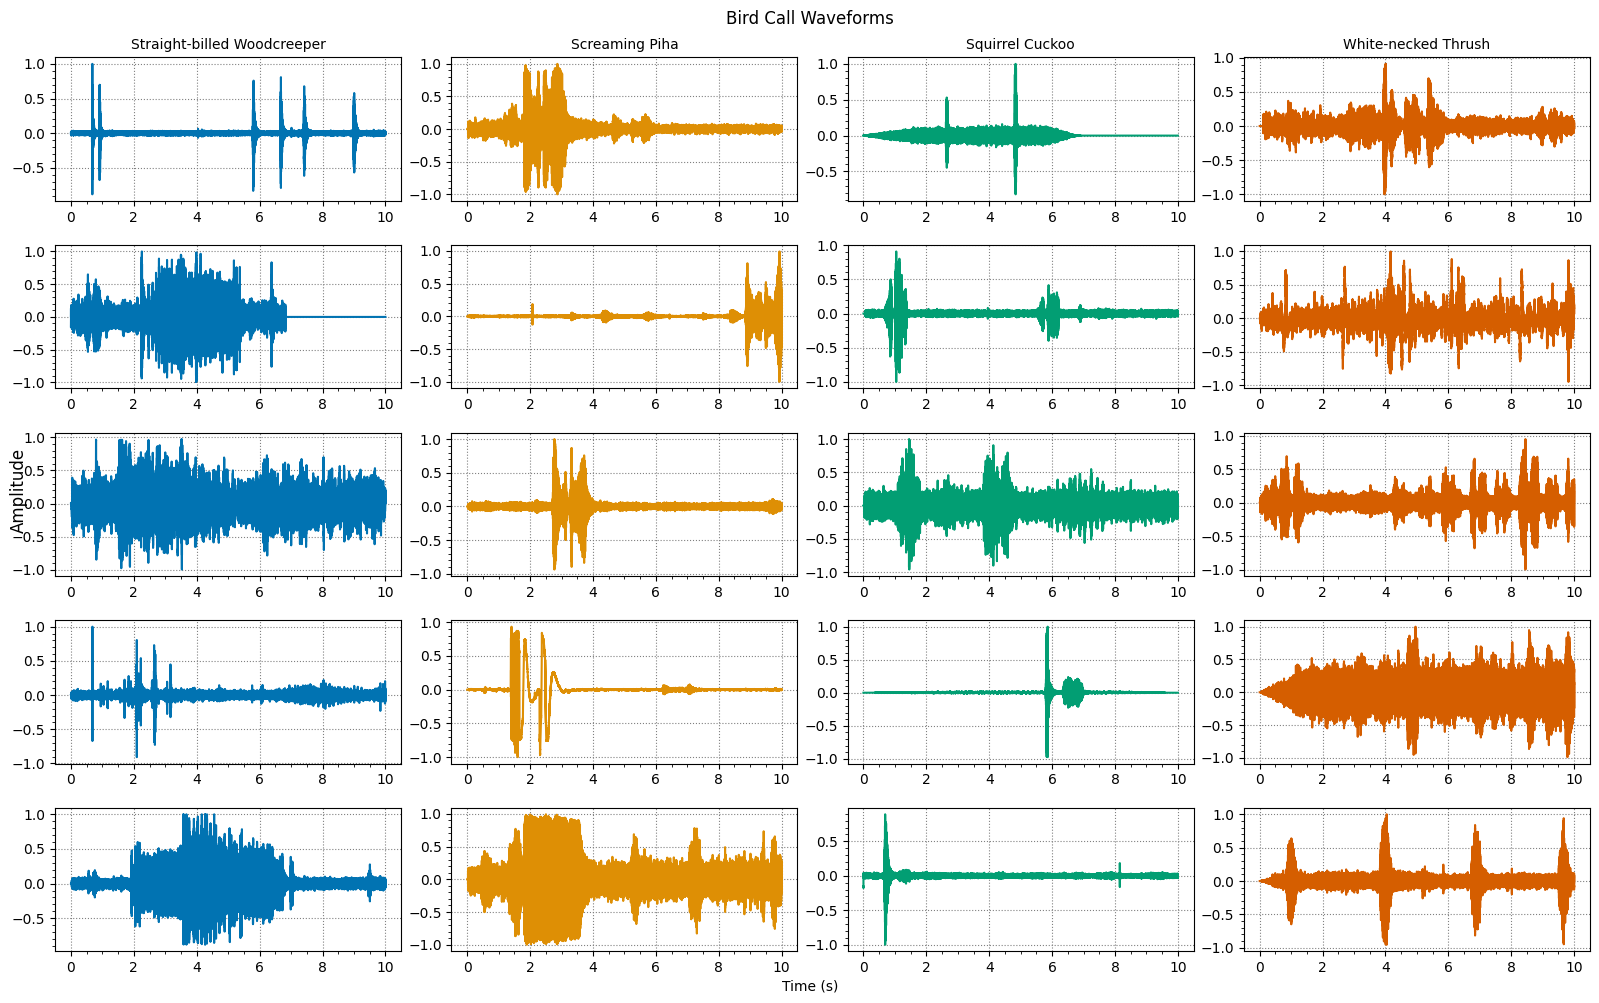

In [76]:
fs = 44100
cnt = 5
labels = ['Straight-billed Woodcreeper', 'Screaming Piha', 'Squirrel Cuckoo', 'White-necked Thrush']
colors = sns.color_palette("colorblind")
fig, axes = plt.subplots(nrows=cnt, ncols=len(labels), figsize=(len(labels)*4, cnt*2))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, l in enumerate(labels):
    for j in range(cnt):
        sample = bird_dict[l][fs][j]

        axes[j][i].plot(np.arange(len(sample)) / fs, sample, color=colors[i])
        if j == 0:
            axes[j][i].set_title(l, fontsize=10)
        axes[j][i].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
        axes[j][i].minorticks_on()
        axes[j][i].grid(True, linestyle=':', linewidth=0.8, color='gray')

fig.text(0.5, 0, 'Time (s)', ha='center', fontsize=10)
fig.text(0, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize=12)
fig.suptitle('Bird Call Waveforms')
plt.savefig('figures/bird_call_waveforms_array.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

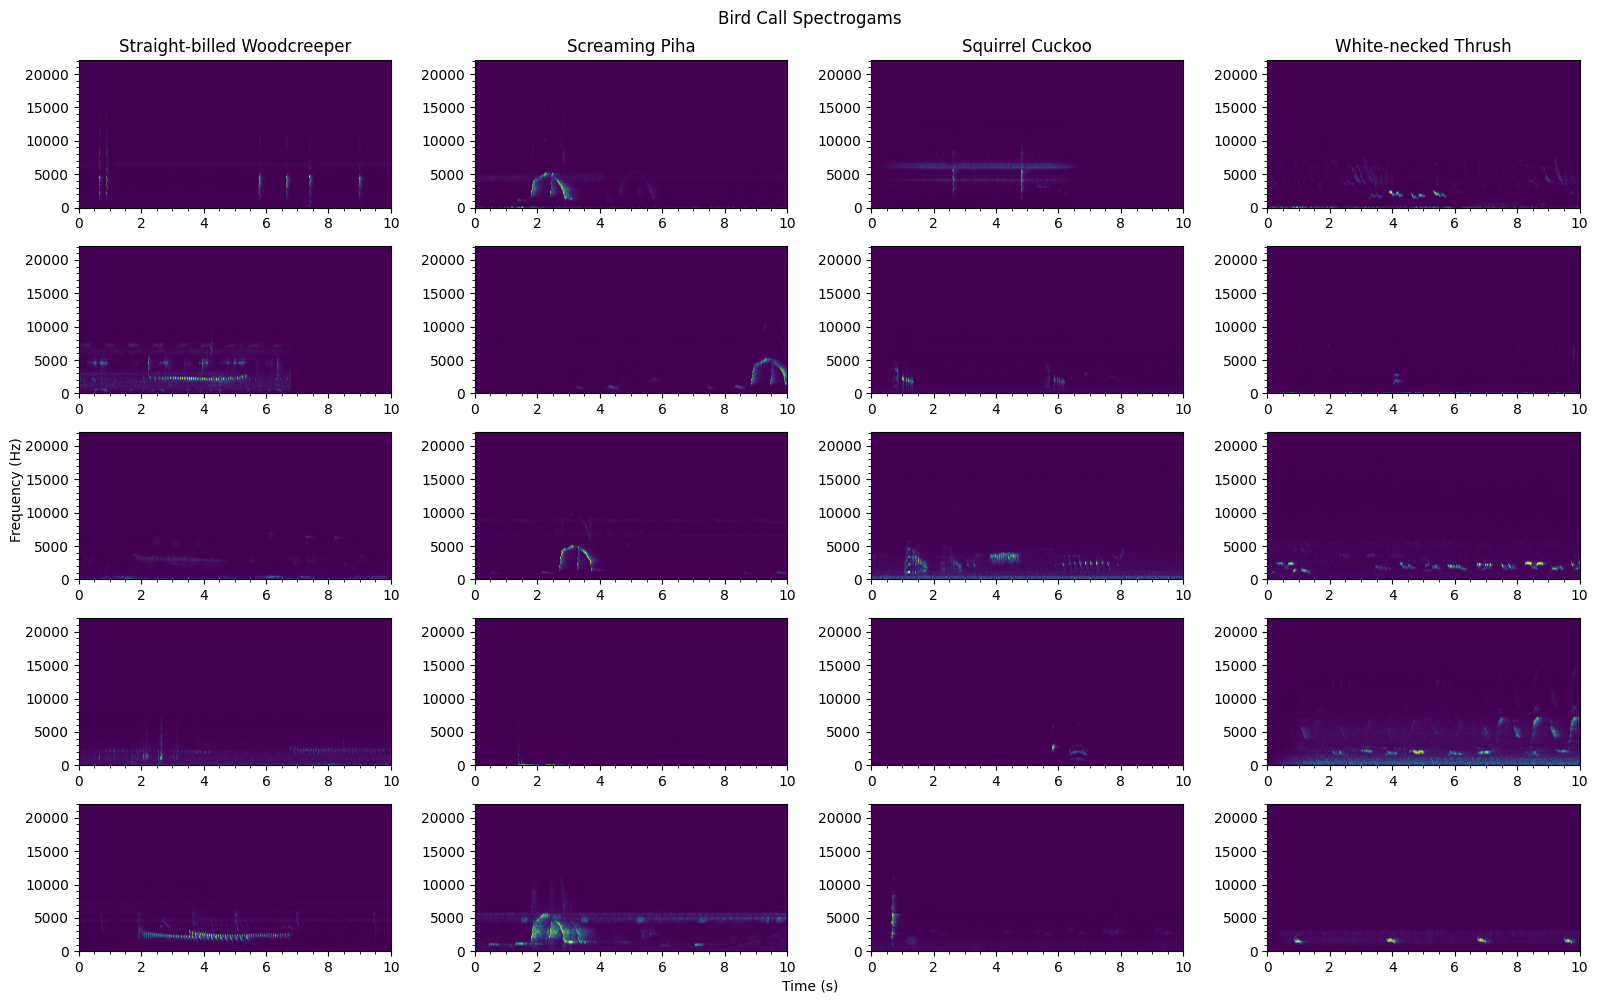

In [54]:
labels = ['Straight-billed Woodcreeper', 'Screaming Piha', 'Squirrel Cuckoo', 'White-necked Thrush']

colors = sns.color_palette("colorblind")
fig, axes = plt.subplots(nrows=cnt, ncols=len(labels), figsize=(len(labels)*4, cnt*2))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, l in enumerate(labels):
    for j in range(cnt):
        sample = bird_dict[l][fs][j]
        f, t, Zxx1 = signal.stft(sample, fs)

        axes[j][i].pcolormesh(t, f, np.abs(Zxx1), vmax=np.abs(np.real(Zxx1)).max()/2, shading='gouraud')
        if j == 0:
            axes[j][i].set_title(l, fontsize=12)

        axes[j][i].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
        axes[j][i].minorticks_on()

fig.text(0.5, 0, 'Time (s)', ha='center', fontsize=10)
fig.text(0, 0.5, 'Frequency (Hz)', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Bird Call Spectrogams')

# plt.savefig('figures/bird_call_spectrogams_array.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

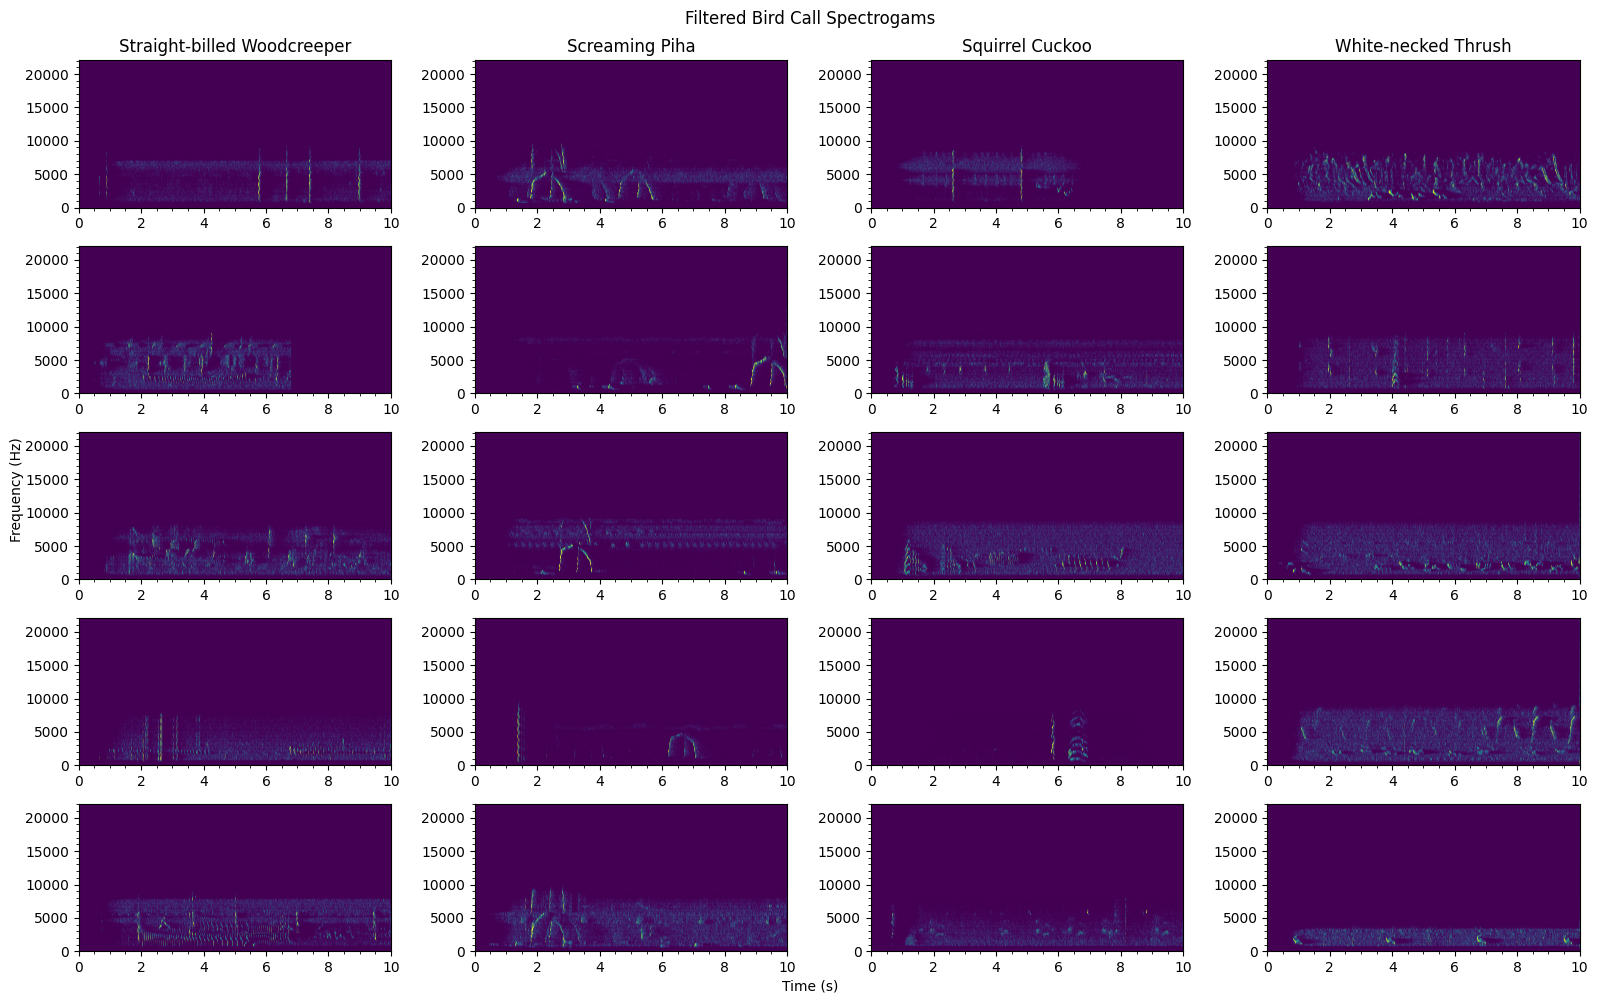

In [56]:
labels = ['Straight-billed Woodcreeper', 'Screaming Piha', 'Squirrel Cuckoo', 'White-necked Thrush']

colors = sns.color_palette("colorblind")
fig, axes = plt.subplots(nrows=cnt, ncols=len(labels), figsize=(len(labels)*4, cnt*2))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, l in enumerate(labels):
    for j in range(cnt):
        sample = bird_dict[l][fs][j]
        t, f, Zxx1 = filter_audio(sample)

        axes[j][i].pcolormesh(t, f, np.abs(Zxx1), vmax=np.abs(np.real(Zxx1)).max()/2, shading='gouraud')
        if j == 0:
            axes[j][i].set_title(l, fontsize=12)

        axes[j][i].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
        axes[j][i].minorticks_on()

fig.text(0.5, 0, 'Time (s)', ha='center', fontsize=10)
fig.text(0, 0.5, 'Frequency (Hz)', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Filtered Bird Call Spectrogams')

# plt.savefig('figures/bird_call_filtered_spectrogams_array.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

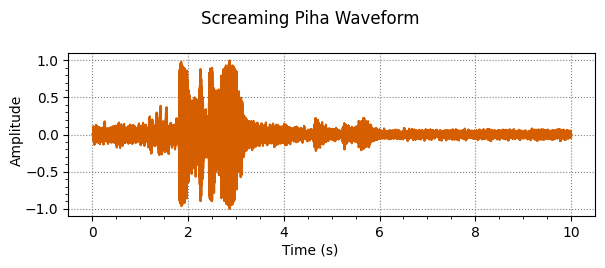

In [67]:
sp = bird_dict["Screaming Piha"][fs][0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2.5))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

ax.plot(np.arange(len(sp)) / fs, sp, color=colors[3])

ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
ax.minorticks_on()
ax.grid(True, linestyle=':', linewidth=0.8, color='gray')

fig.text(0.5, 0, 'Time (s)', ha='center', fontsize=10)
fig.text(0, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Screaming Piha Waveform')

# plt.savefig('figures/piha_bird_call_waveform.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

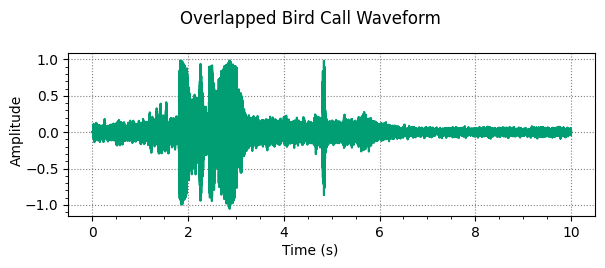

In [77]:
overlap_sample = bird_dict["Screaming Piha"][fs][0] + bird_dict["Squirrel Cuckoo"][fs][0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2.5))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

ax.plot(np.arange(len(overlap_sample)) / fs, overlap_sample, color=colors[2])

ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
ax.minorticks_on()
ax.grid(True, linestyle=':', linewidth=0.8, color='gray')

fig.text(0.5, 0, 'Time (s)', ha='center', fontsize=10)
fig.text(0, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Overlapped Bird Call Waveform')

# plt.savefig('figures/overlapped_bird_call_waveform.png')
plt.tight_layout()
plt.show()

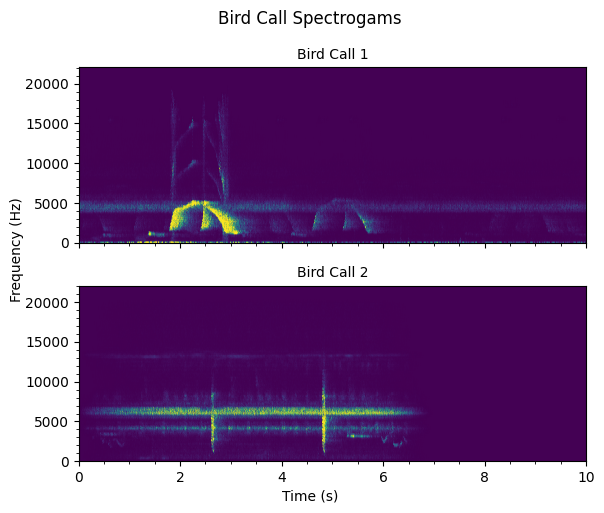

In [ ]:
f, t, Zxx1 = signal.stft(single_sample_1, fs)
f, t, Zxx2 = signal.stft(single_sample_2, fs)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

axes[0].pcolormesh(t, f, np.abs(Zxx1), vmax=np.abs(np.real(Zxx1)).max()/10, shading='gouraud')
axes[0].set_title("Bird Call 1", fontsize=10)

axes[1].pcolormesh(t, f, np.abs(Zxx2), vmax=np.abs(np.real(Zxx2)).max()/10, shading='gouraud')
axes[1].set_title("Bird Call 2", fontsize=10)

axes[0].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axes[1].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
axes[0].minorticks_on()
axes[1].minorticks_on()

fig.text(0.5, 0, 'Time (s)', ha='center', fontsize=10)
fig.text(0, 0.5, 'Frequency (Hz)', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Bird Call Spectrogams')

# plt.savefig('figures/bird_call_spectrogams.png')
plt.tight_layout()
plt.show()

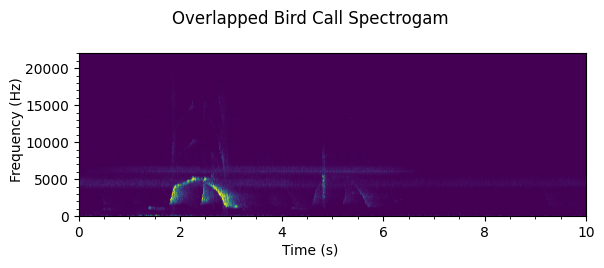

In [81]:
f, t, Zxx3 = signal.stft(overlap_sample, fs)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2.5))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

ax.pcolormesh(t, f, np.abs(Zxx3), vmax=np.abs(np.real(Zxx3)).max()/3, shading='gouraud')

ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
ax.minorticks_on()

fig.text(0.5, 0, 'Time (s)', ha='center', fontsize=10)
fig.text(0, 0.5, 'Frequency (Hz)', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Overlapped Bird Call Spectrogam')

# plt.savefig('figures/overlapped_bird_call_spectrogram.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

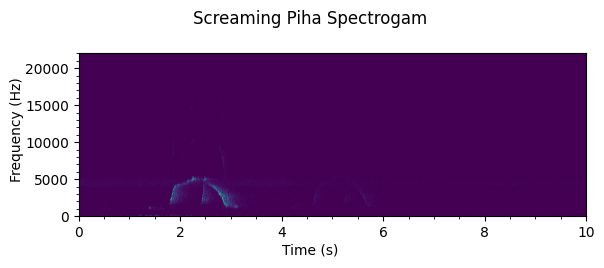

In [83]:
f, t, Zxx3 = signal.stft(sp, fs)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2.5))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

ax.pcolormesh(t, f, np.abs(Zxx3), vmax=np.abs(np.real(Zxx3)).max(), shading='gouraud')

ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
ax.minorticks_on()

fig.text(0.5, 0, 'Time (s)', ha='center', fontsize=10)
fig.text(0, 0.5, 'Frequency (Hz)', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Screaming Piha Spectrogam')

plt.savefig('figures/piha_bird_call_spectrogram.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

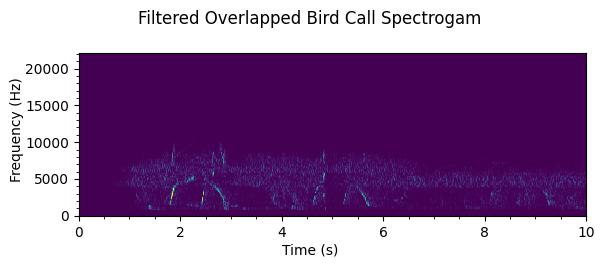

In [84]:
t, f, fZxx = filter_audio(overlap_sample)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2.5))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

ax.pcolormesh(t, f, fZxx, vmax=np.abs(np.real(fZxx)).max(), shading="nearest")

ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
ax.minorticks_on()

fig.text(0.5, 0, 'Time (s)', ha='center', fontsize=10)
fig.text(0, 0.5, 'Frequency (Hz)', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Filtered Overlapped Bird Call Spectrogam')

# plt.savefig('figures/filtered_overlapped_bird_call_spectrogam.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

<Figure size 900x400 with 0 Axes>

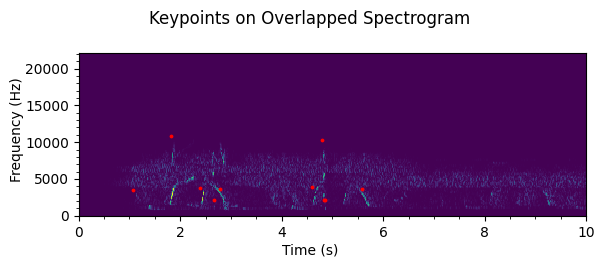

In [413]:
t, f, filtered_audio, kps, mat = get_keypoints(overlap_sample, 100)
graph_keypoints(t, f, kps, background=True, original=overlap_sample)

<Figure size 900x400 with 0 Axes>

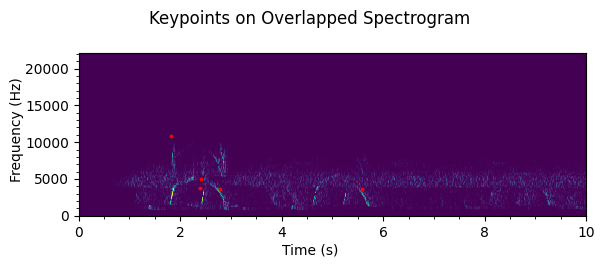

In [419]:
t, f, filtered_audio, kps, mat = get_keypoints(single_sample_1, 5)
graph_keypoints(t, f, kps, True, single_sample_1)

<Figure size 900x400 with 0 Axes>

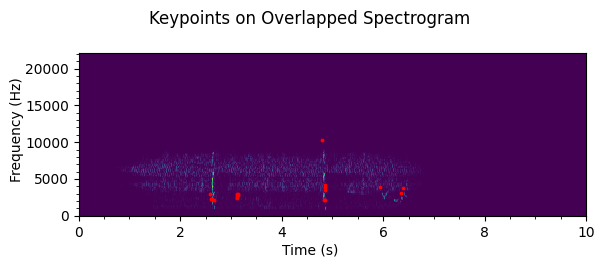

(129, 3447)

In [420]:
t, f, filtered_audio, kps, mat = get_keypoints(single_sample_2, 20)
graph_keypoints(t, f, kps, True, single_sample_2)
mat.shape

In [437]:
def create_svm_data(N=50):
  fs = 44100
  birds = list(bird_dict.keys())
  woodcreeper = bird_dict[birds[0]][fs][:100]
  piha = bird_dict[birds[1]][fs][-100:]
  cuckoo = bird_dict[birds[2]][fs][20:70] + bird_dict[birds[2]][fs][85:135]
  thrush = bird_dict[birds[3]][fs][-50:-29] + bird_dict[birds[3]][fs][-100:-60] + bird_dict[birds[3]][fs][:39]
  X = []
  observations = (woodcreeper, piha, cuckoo, thrush)
  for idx1, i in enumerate(observations):
    for idx2, j in enumerate(i):
      # print("[{}]: {}".format(birds[idx1], idx2))
      t, f, filtered_audio, kps, mat = get_keypoints(j, N)
      X.append(kps.flatten())
  return np.array(X)

X = create_svm_data()
X = pd.DataFrame(X)
X.to_csv("X_single.csv", index=False)

# X = pd.read_csv("X_single.csv")

X = np.array(X)
y_woodcreeper = [0]*100
y_piha = [1]*100
y_cuckoo = [2]*100
y_thrush = [3]*100
y = np.concatenate((y_woodcreeper, y_piha, y_cuckoo, y_thrush))
X

array([[3.33754793e-01, 5.08807256e+00, 6.89062500e+03, ...,
        2.20500000e+04, 1.00000000e+01, 4.00743850e-02],
       [2.55619147e-01, 4.50757370e+00, 4.30664062e+03, ...,
        2.20500000e+04, 1.60000000e+01, 2.82726560e-02],
       [3.00461622e-01, 4.48435374e+00, 3.61757812e+03, ...,
        2.20500000e+04, 1.60000000e+01, 4.18654801e-02],
       ...,
       [2.80583197e-01, 5.08807256e+00, 8.61328125e+03, ...,
        2.20500000e+04, 1.40000000e+01, 4.05657198e-02],
       [1.47762019e-01, 1.21034014e+00, 8.95781250e+03, ...,
        2.20500000e+04, 1.10000000e+01, 1.86473595e-02],
       [2.59275200e-01, 2.25523810e+00, 3.78984375e+03, ...,
        2.20500000e+04, 1.50000000e+01, 3.99425999e-02]])

In [435]:
# y_woodcreeper = [0]*100
# y_piha = [1]*100
# y_cuckoo = [2]*100
# y_thrush = [3]*100
# y = np.concatenate((y_woodcreeper, y_piha, y_cuckoo, y_thrush))
# accuracies = []
# for N in range(10, 201, 20):
#     X = create_svm_data(N)

#     num_iterations = 100
#     test_size = 0.33

#     acc = []
#     preds = np.zeros(4)
#     obs = np.zeros(4)
#     for _ in range(num_iterations):
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
#         random.seed(36)
#         model = svm.SVC(kernel='rbf', decision_function_shape='ovo')
#         model.fit(X_train, y_train)

#         y_pred = model.predict(X_test)
#         accuracy = accuracy_score(y_test, y_pred)
#         acc.append(accuracy)
#     accuracies.append(np.mean(acc))
# accuracies

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (400,) + inhomogeneous part.

In [503]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# Initialize SVM classifier
svm = SVC()

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

svm_classifier = SVC(**best_params)
svm_classifier.fit(X_train, y_train)

y_pred_train = svm_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

y_pred_test = svm_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print(np.unique(y_pred_test, return_counts=True))
print(np.unique(y_pred_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

Train Accuracy: 1.0
Test Accuracy: 0.2196969696969697
(array([0, 1, 2, 3]), array([37, 44, 23, 28]))
(array([0, 1, 2, 3]), array([63, 68, 67, 70]))
(array([0, 1, 2, 3]), array([37, 32, 33, 30]))


In [504]:
best_params

{'C': 0.1, 'kernel': 'linear'}

[10032. 10042.  9515. 10011.]
[9943. 9928. 9899. 9830.]


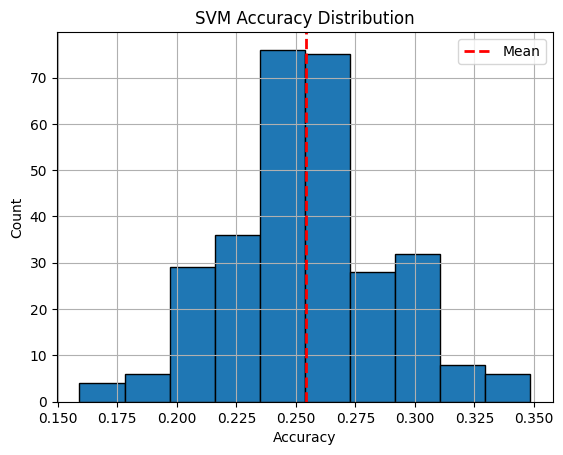

In [482]:
num_iterations = 300
test_size = 0.33

accuracies = []
preds = np.zeros(4)
obs = np.zeros(4)
for _ in range(num_iterations):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    random.seed(36)
    model = SVC(**best_params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    pred_counts = np.unique(y_pred, return_counts=True)
    obs_counts = np.unique(y_test, return_counts=True)
    preds[pred_counts[0]] += pred_counts[1]
    obs[obs_counts[0]] += obs_counts[1]

print(preds)
print(obs)

plt.hist(accuracies, bins=10, edgecolor='black')
plt.axvline(np.mean(accuracies), color='r', linestyle='dashed', linewidth=2, label='Mean')

# Add legend
plt.legend()
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.title('SVM Accuracy Distribution')
plt.grid(True)

# plt.savefig("figures/accuracy_distribution_svm.png")
plt.show()

In [506]:
# X = pd.read_csv("X_single.csv")
# X = np.array(X)

# y_woodcreeper = [0]*100
# y_piha = [1]*100
# y_cuckoo = [2]*100
# y_thrush = [3]*100
# y = np.concatenate((y_woodcreeper, y_piha, y_cuckoo, y_thrush))

model = SVC(**best_params)
model.fit(X, y)

y_pred_test = model.predict_proba(X_lap)
y_pred = np.argsort(y_pred_test)[:,:-2-1:-1]

scores = []
for i in range(len(y_pred)):
  score = 0
  for j in range(2):
    if y_pred[i][j] in y_lap[i]:
      score += 1
  scores.append(score)
print(np.mean(scores))
print(np.unique(scores, return_counts=True))

ValueError: y should be a 1d array, got an array of shape (800, 4) instead.

In [501]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17]}

# Initialize KNN classifier
knn = KNeighborsClassifier()

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = grid_search.best_params_
print(best_params)

# Train final model with best hyperparameters
knn_classifier = KNeighborsClassifier(**best_params)
knn_classifier.fit(X_train, y_train)

y_pred_train = knn_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

y_pred_test = knn_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print(np.unique(y_pred_test, return_counts=True))
print(np.unique(y_pred_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

{'n_neighbors': 11}
Train Accuracy: 0.39552238805970147
Test Accuracy: 0.22727272727272727
(array([0, 1, 2, 3]), array([50, 65,  9,  8]))
(array([0, 1, 2, 3]), array([108, 126,  11,  23]))
(array([0, 1, 2, 3]), array([31, 29, 37, 35]))


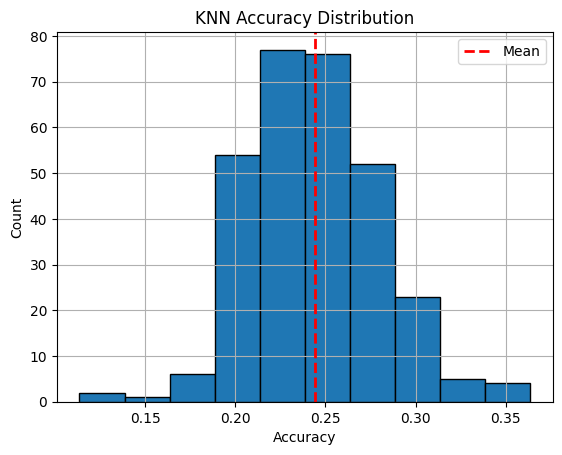

In [502]:
num_iterations = 300
test_size = 0.33

accuracies = []
preds = np.zeros(4)
obs = np.zeros(4)
for _ in range(num_iterations):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    random.seed(36)
    model = KNeighborsClassifier(**best_params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    pred_counts = np.unique(y_pred, return_counts=True)
    obs_counts = np.unique(y_test, return_counts=True)
    preds[pred_counts[0]] += pred_counts[1]
    obs[obs_counts[0]] += obs_counts[1]

# print(preds)
# print(obs)

plt.hist(accuracies, bins=10, edgecolor='black')
plt.axvline(np.mean(accuracies), color='r', linestyle='dashed', linewidth=2, label='Mean')

# Add legend
plt.legend()
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.title('KNN Accuracy Distribution')
plt.grid(True)

# plt.savefig("figures/accuracy_distribution_knn.png")
plt.show()

# CNN Models (Single)

In [126]:
def create_cnn_data():
  fs = 44100
  N = 200
  birds = list(bird_dict.keys())
  woodcreeper = bird_dict[birds[0]][fs][:171]
  piha = bird_dict[birds[1]][fs][:171]
  cuckoo = bird_dict[birds[2]][fs][:171]
  thrush = bird_dict[birds[3]][fs][:171]
  M = []
  B = []
  observations = (woodcreeper, piha, cuckoo, thrush)
  for idx1, i in enumerate(observations):
    for idx2, j in enumerate(i):
      # print("[{}]: {}".format(birds[idx1], idx2))
      t, f, filtered_audio, kps, mat = get_keypoints(j, N)
      _t, _f, mat2 = filter_audio(j)
      M.append(mat.reshape((129, 3447, 1)))
      B.append(mat2.reshape((129, 3447, 1)))
  return np.array(M), np.array(B)

M, B = create_cnn_data()
# pd.DataFrame(M.reshape((171*4, 129*3447))).to_csv("M_single.csv", index=False)
# pd.DataFrame(B.reshape((171*4, 129*3447))).to_csv("B_single.csv", index=False)

In [166]:
y_woodcreeper = np.array([[1, 0, 0, 0]]*171)
y_piha = np.array([[0, 1, 0, 0]]*171)
y_cuckoo = np.array([[0, 0, 1, 0]]*171)
y_thrush = np.array([[0, 0, 0, 1]]*171)
y = np.concatenate((y_woodcreeper, y_piha, y_cuckoo, y_thrush))

X_train, X_test, y_train, y_test = train_test_split(M, y, test_size=0.2, random_state=36)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=36)
# Define the input shape
input_shape = (129, 3447, 1)  # Assuming grayscale images with size 129x3447

# Define the CNN model
single_kp_cnn = Sequential([
    Conv2D(32, kernel_size=(10, 6), activation='relu', kernel_initializer='he_normal', input_shape=input_shape),
    MaxPooling2D(pool_size=(3, 5)),
    Dropout(0.4),
    Conv2D(64, kernel_size=(10, 6), activation='relu'),
    MaxPooling2D(pool_size=(3, 4)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # Output layer with 4 units for 4 classes
])

# Compile the model
single_kp_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
single_kp_cnn.summary()

# Train your model
# single_kp_cnn.fit(X_train, y_train, epochs=6, batch_size=64, validation_data=(X_val, y_val))

# Evaluate your model
loss, accuracy = single_kp_cnn.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


/Users/dstockard/Documents/audio/.conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 120, 3442, 32)  │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 40, 688, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 40, 688, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 31, 683, 64)    │       122,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 170, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 170, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 108800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    13,926,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,051,940 (53.60 MB)

 Trainable params: 14,051,940 (53.60 MB)

 Non-trainable params: 0 (0.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 564ms/step - accuracy: 0.2844 - loss: 1.3809
Test Accuracy: 0.29197078943252563


In [163]:
# single_kp_cnn.save('single_kp_cnn.keras')
single_kp_cnn = load_model('single_kp_cnn.keras')

In [180]:
y_pred_test

array([[0, 1, 0, 1],
       [1, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [0, 1, 1, 0],
       [1, 0, 0, 1],
       [1, 1, 0, 0],
       [1, 0, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 1, 1, 0],
       [1, 0, 0, 1],
       [0, 0, 1, 1],
       [0, 1, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [1, 1, 0, 0],
       [0, 1, 1, 0],
       [1, 0, 0, 1],
       [0, 1, 0, 1],
       [1, 0, 0, 1],
       [1, 1, 0, 0],
       [0, 0, 1, 1],
       [0, 1, 1, 0],
       [0, 1, 0, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [0, 0, 1, 1],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [0, 1, 1, 0],
       [1, 0, 1, 0],
       [0, 1, 1, 0],
       [1, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 1],
       [0, 0, 1, 1],
       [1, 1, 0, 0],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 1, 1, 0],
       [0, 0, 1, 1],
       [0, 1,

In [164]:
output_probabilities = single_kp_cnn.predict(X_test)

# Convert probabilities to predictions
predictions = np.zeros_like(output_probabilities)
predictions[np.arange(len(output_probabilities)), output_probabilities.argmax(axis=1)] = 1

predictions = np.array(predictions).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 689ms/step


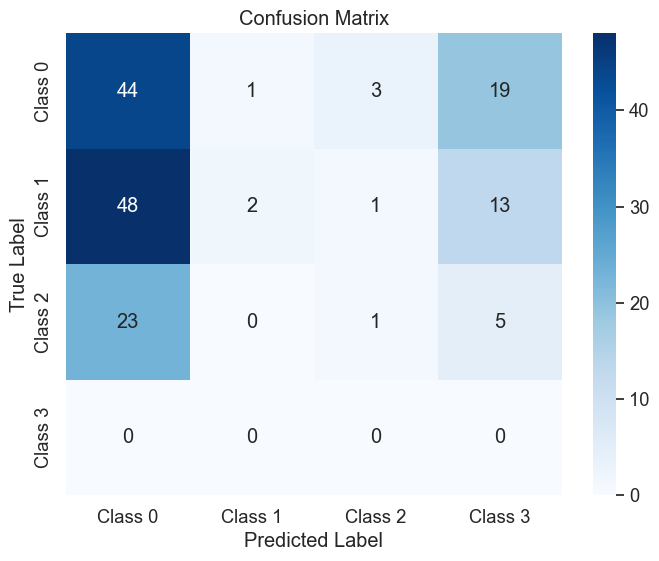

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example confusion matrix
conf_matrix = confusion_matrix(y_test.argmax(axis=1), output_probabilities.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Set font scale
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
# plt.savefig("figures/confusion_matrix.png")
plt.show()


In [167]:
# B = pd.read_csv("B_single.csv")
# B = np.array(B).reshape((400, 129, 3447, 1))

y_woodcreeper = np.array([[1, 0, 0, 0]]*171)
y_piha = np.array([[0, 1, 0, 0]]*171)
y_cuckoo = np.array([[0, 0, 1, 0]]*171)
y_thrush = np.array([[0, 0, 0, 1]]*171)
y = np.concatenate((y_woodcreeper, y_piha, y_cuckoo, y_thrush))

X_train, X_test, y_train, y_test = train_test_split(B, y, test_size=0.2, random_state=36)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=36)

# Define the input shape
input_shape = (129, 3447, 1)  # Assuming grayscale images with size 129x3447

# Define the CNN model
single_bl_cnn = Sequential([
    Conv2D(32, kernel_size=(10, 6), activation='relu', kernel_initializer='he_normal', input_shape=input_shape),
    MaxPooling2D(pool_size=(3, 5)),
    Dropout(0.4),
    Conv2D(64, kernel_size=(10, 6), activation='relu'),
    MaxPooling2D(pool_size=(3, 4)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # Output layer with 4 units for 4 classes
])

# Compile the model
single_bl_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
single_bl_cnn.summary()

# Train your model
# single_bl_cnn.fit(X_train, y_train, epochs=6, batch_size=64, validation_data=(X_val, y_val))

# Evaluate your model
loss, accuracy = single_bl_cnn.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 120, 3442, 32)  │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 40, 688, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 40, 688, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 31, 683, 64)    │       122,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 10, 170, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10, 170, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 108800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    13,926,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,051,940 (53.60 MB)

 Trainable params: 14,051,940 (53.60 MB)

 Non-trainable params: 0 (0.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 806ms/step - accuracy: 0.3303 - loss: 1.3815
Test Accuracy: 0.31386861205101013


In [14]:
single_bl_cnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 124, 3438, 32)  │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 1146, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 22, 1141, 64)   │       122,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 22, 380, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 535040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    68,485,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,610,660 (261.73 MB)

 Trainable params: 68,610,660 (261.73 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
# single_bl_cnn.save('single_bl_cnn.keras')
single_bl_cnn = load_model('single_bl_cnn.keras')

# CNN Models (Overlap)

In [172]:
X_lap, y_lap, M_lap, B_lap = generate_samples(800, n=200)
y = []
for i in y_lap:
    out = np.zeros(4).astype(int)
    out[i] = 1
    y.append(out)
y = np.array(y)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(M_lap, y, test_size=0.2, random_state=36)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=36)

# Define the input shape
input_shape = (129, 3447, 1)  # Assuming grayscale images with size 129x3447

# Define the CNN model
double_kp_cnn = Sequential([
    Conv2D(32, kernel_size=(10, 6), activation='relu', kernel_initializer='he_normal', input_shape=input_shape),
    MaxPooling2D(pool_size=(3, 5)),
    Dropout(0.4),
    Conv2D(64, kernel_size=(10, 6), activation='relu'),
    MaxPooling2D(pool_size=(3, 4)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='sigmoid')  # Output layer with 4 units for 4 classes
])

# Compile the model
double_kp_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
double_kp_cnn.summary()

# Train your model
double_kp_cnn.fit(X_train, y_train, epochs=6, batch_size=64, validation_data=(X_val, y_val))

# Evaluate your model
loss, accuracy = double_kp_cnn.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 120, 3442, 32)  │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 40, 688, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 40, 688, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 31, 683, 64)    │       122,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 10, 170, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 10, 170, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 108800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │    13,926,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,051,940 (53.60 MB)

 Trainable params: 14,051,940 (53.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 98s 12s/step - accuracy: 0.3757 - loss: 0.7407 - val_accuracy: 0.2937 - val_loss: 0.6905
Epoch 2/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 96s 12s/step - accuracy: 0.4558 - loss: 0.6509 - val_accuracy: 0.4563 - val_loss: 0.6804
Epoch 3/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 95s 12s/step - accuracy: 0.5332 - loss: 0.5224 - val_accuracy: 0.3562 - val_loss: 0.6497
Epoch 4/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 97s 12s/step - accuracy: 0.5212 - loss: 0.3937 - val_accuracy: 0.4563 - val_loss: 0.7064
Epoch 5/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 103s 13s/step - accuracy: 0.5142 - loss: 0.2727 - val_accuracy: 0.4625 - val_loss: 0.6969
Epoch 6/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 102s 12s/step - accuracy: 0.5549 - loss: 0.1890 - val_accuracy: 0.4125 - val_loss: 0.7767
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step - accuracy: 0.4057 - loss: 0.8534
Test Accuracy: 0.3812499940395355


In [183]:
def convert_to_two_largest(probabilities):
    # Sort probabilities in descending order and get the indices
    sorted_indices = np.argsort(probabilities)[::-1]

    # Initialize the output array with zeros
    output = np.zeros_like(probabilities)

    # Set the top two probabilities to 1
    output[sorted_indices[:2]] = 1

    return output.astype(int)

y_pred_test = double_kp_cnn.predict(X_test)
y_pred_test = np.array([convert_to_two_largest(y) for y in y_pred_test])
y_pred_test[:5]

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 764ms/step


array([[0, 1, 0, 1],
       [1, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1]])

In [175]:
scores = []
for i in range(len(y_pred_test)):
  score = 0
  for j in range(2):
    if y_pred_test[i][j] == y_test[i][j]:
      score += 1
  scores.append(score)
np.mean(scores)

1.39375

In [176]:
np.unique(scores, return_counts=True)

(array([0, 1, 2]), array([18, 61, 81]))

In [177]:
y_pred_test.sum(axis=0)

array([ 77,  47,  95, 101])

In [178]:
y_test.sum(axis=0)

array([89, 72, 78, 81])

In [184]:
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np

# Example true labels and predicted labels (binary representation)
true_labels = np.array([[1, 0, 1],  # Sample 1: True labels for classes A, C
                        [0, 1, 0],  # Sample 2: True labels for class B
                        [1, 1, 0],  # Sample 3: True labels for classes A, B
                        [0, 0, 1]]) # Sample 4: True labels for class C

predicted_labels = np.array([[1, 0, 1],  # Sample 1: Predicted labels for classes A, C
                             [0, 1, 0],  # Sample 2: Predicted labels for class B
                             [1, 0, 0],  # Sample 3: Predicted labels for class A
                             [0, 1, 1]]) # Sample 4: Predicted labels for classes B, C

# Compute multi-label confusion matrix
conf_matrix = multilabel_confusion_matrix(y_test, y_pred_test)

# Print confusion matrix for each class
for i, matrix in enumerate(conf_matrix):
    print(f'Confusion matrix for class {i+1}:')
    print(matrix)


Confusion matrix for class 1:
[[51 20]
 [32 57]]
Confusion matrix for class 2:
[[78 10]
 [35 37]]
Confusion matrix for class 3:
[[44 38]
 [21 57]]
Confusion matrix for class 4:
[[41 38]
 [18 63]]


In [146]:
# double_kp_cnn.save('double_kp_cnn.keras')
double_kp_cnn = load_model('double_kp_cnn.keras')

In [185]:
conf_matrix

array([[[51, 20],
        [32, 57]],

       [[78, 10],
        [35, 37]],

       [[44, 38],
        [21, 57]],

       [[41, 38],
        [18, 63]]])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(B_lap, y, test_size=0.2, random_state=36)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=36)

# Define the input shape
input_shape = (129, 3447, 1)  # Assuming grayscale images with size 129x3447

# Define the CNN model
double_bl_cnn = Sequential([
    Conv2D(32, kernel_size=(10, 6), activation='relu', kernel_initializer='he_normal', input_shape=input_shape),
    MaxPooling2D(pool_size=(3, 5)),
    Dropout(0.4),
    Conv2D(64, kernel_size=(10, 6), activation='relu'),
    MaxPooling2D(pool_size=(3, 4)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='sigmoid')  # Output layer with 4 units for 4 classes
])

# Compile the model
double_bl_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
double_bl_cnn.summary()

# Train your model
double_bl_cnn.fit(X_train, y_train, epochs=6, batch_size=64, validation_data=(X_val, y_val))

# Evaluate your model
loss, accuracy = double_bl_cnn.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 120, 3442, 32)  │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 40, 688, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 40, 688, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 31, 683, 64)    │       122,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 170, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 10, 170, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 108800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    13,926,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,051,940 (53.60 MB)

 Trainable params: 14,051,940 (53.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 121s 15s/step - accuracy: 0.2146 - loss: 1.1524 - val_accuracy: 0.3313 - val_loss: 0.6931
Epoch 2/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 114s 14s/step - accuracy: 0.1391 - loss: 0.6928 - val_accuracy: 0.3688 - val_loss: 0.6930
Epoch 3/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 124s 15s/step - accuracy: 0.3499 - loss: 0.6931 - val_accuracy: 0.3688 - val_loss: 0.6929
Epoch 4/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 121s 15s/step - accuracy: 0.3586 - loss: 0.6930 - val_accuracy: 0.3688 - val_loss: 0.6928
Epoch 5/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 119s 15s/step - accuracy: 0.3661 - loss: 0.6930 - val_accuracy: 0.3688 - val_loss: 0.6927
Epoch 6/6
8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 14s/step - accuracy: 0.3481 - loss: 0.6930 - val_accuracy: 0.3688 - val_loss: 0.6927
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 775ms/step - accuracy: 0.3655 - loss: 0.6933
Test Accuracy: 0.3687500059604645


In [99]:
y_pred_test = double_bl_cnn.predict(X_test)
y_pred_test = np.array([convert_to_two_largest(y) for y in y_pred_test])

scores = []
for i in range(len(y_pred_test)):
  score = 0
  for j in range(2):
    if y_pred_test[i][j] == y_test[i][j]:
      score += 1
  scores.append(score)
np.mean(scores)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 767ms/step


1.03125

In [101]:
np.unique(y_pred_test, return_counts=True)

(array([0, 1]), array([320, 320]))

In [103]:
np.unique(scores, return_counts=True)

(array([0, 1, 2]), array([50, 55, 55]))

In [98]:
# double_bl_cnn.save('double_bl_cnn.keras')
double_bl_cnn = load_model('double_bl_cnn.keras')

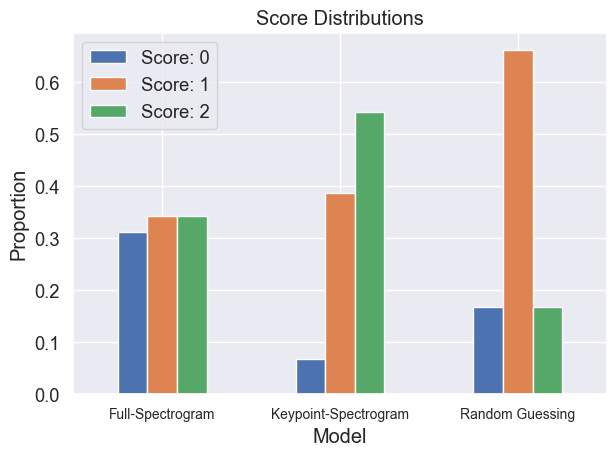

In [162]:
fspec = pd.Series([50, 55, 55])/160
kspec = pd.Series([11, 62, 87])/160
rguess = pd.Series([27, 106, 27])/160

df = pd.DataFrame([fspec, kspec, rguess])
df.index = ["Full-Spectrogram", "Keypoint-Spectrogram", "Random Guessing"]
df.columns = ["Score: 0", "Score: 1", "Score: 2"]
ax = df.plot.bar()

plt.title('Score Distributions')
plt.xlabel('Model')
plt.ylabel('Proportion')

ax.set_xticklabels(df.index, fontsize=10, rotation=0)
plt.tight_layout()
plt.savefig("figures/score_distributions.png")
plt.show()